# Spam detection model using Natural Language Processing 
## 1. Import module 

In [1]:
import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## 2. Data download and inspection 
### 2.1 Download data 

In [2]:
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
data_df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


In [3]:
data_df.drop_duplicates(inplace=True)
data_df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2993,https://www.theverge.com/2020/6/29/21306889/di...,False
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


- Duplicates removed and index need to be reset! 

In [4]:
data_df.reset_index(inplace=True, drop=True)
data_df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2364,https://www.theverge.com/2020/6/29/21306889/di...,False
2365,https://www.smartcitiesworld.net/news/news/dee...,False
2366,https://techcrunch.com/2019/07/04/an-optimisti...,False
2367,https://www.technologyreview.com/2019/12/20/13...,False


### 2.2 Data Inspection 

In [5]:
data_df.head()


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [6]:
data_df.tail()

,url,is_spam
2364,https://www.theverge.com/2020/6/29/21306889/di...,False
2365,https://www.smartcitiesworld.net/news/news/dee...,False
2366,https://techcrunch.com/2019/07/04/an-optimisti...,False
2367,https://www.technologyreview.com/2019/12/20/13...,False
2368,https://www.bbc.com/news/technology-51018758,False


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2369 non-null   object
 1   is_spam  2369 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 21.0+ KB


In [8]:
data_df.describe()

,url,is_spam
count,2369,2369
unique,2369,2
top,https://www.bbc.com/news/technology-51018758,False
freq,1,2125


### 2.3 Train-test split 

In [9]:
labels=data_df['is_spam']
features=data_df.drop('is_spam', axis=1)
features.head()

,url
0,https://briefingday.us8.list-manage.com/unsubs...
1,https://www.hvper.com/
2,https://briefingday.com/m/v4n3i4f3
3,https://briefingday.com/n/20200618/m#commentform
4,https://briefingday.com/fan


In [10]:
labels.head()

0     True
1     True
2     True
3    False
4     True
Name: is_spam, dtype: bool

#### 2.3.1 Encode labels 

In [12]:
encoded_labels=labels.apply(lambda x: 1 if x else 0).astype(int)
encoded_labels.head()

0    1
1    1
2    1
3    0
4    1
Name: is_spam, dtype: int64

#### 2.3.2 Train Test Split 

In [13]:
training_features, testing_features, encoded_training_labels, encoded_testing_labels=train_test_split(features, encoded_labels, test_size=0.25, random_state=315)

In [14]:
training_features.shape, testing_features.shape

((1776, 1), (593, 1))

In [16]:
encoded_training_labels.shape, encoded_testing_labels.shape

((1776,), (593,))

## 3. EDA 

In [18]:
sum(encoded_training_labels)

188

In [21]:
percent_spam=(sum(encoded_training_labels) / len(encoded_training_labels)) * 100
print(f'Training data is {percent_spam:.2f}% of spam urls.')

Training data is 10.59% of spam urls.


### 3.1 Text preprocessing 

- Function to clean and prepare raw text data! 

In [22]:
def preprocess_text(text):

    # Remove any character that is not a letter (a-z) or white space ( )
    text=re.sub(r'[^a-z ]', ' ', text)
    
    # Remove white spaces
    text=re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text=re.sub(r'\^[a-zA-Z]\s+', ' ', text)

    # Multiple white spaces into one
    text=re.sub(r'\s+', ' ', text.lower())

    # Remove tags
    text=re.sub('&lt;/?.*?&gt;',' &lt;&gt; ', text)

    # Remove 'http', 'https' and 'www'
    # text=re.sub('https', '', text)
    # text=re.sub('http', '', text)
    text=re.sub('www', '', text)

    return text.split()

training_features['url']=training_features['url'].apply(preprocess_text)
training_features.head()

,url
311,"[https, nytimes, com, us, into, the, wild, bus..."
2317,"[https, digg, cmail, com, t, ptuurik, vkjjhbly..."
1953,"[http, snarkmarket, com]"
1872,"[https, youtube, com, watch, d, u]"
1752,"[https, wired, com, story, amazon, shakes, sel..."


### 3.2 Lemmatization, stopword removal and filter short words

In [23]:
download('wordnet')
lemmatizer=WordNetLemmatizer()

download('stopwords')
stop_words=stopwords.words('english')

def lemmatize_text(words, lemmatizer=lemmatizer):
    tokens=[lemmatizer.lemmatize(word) for word in words]
    tokens=[word for word in tokens if word not in stop_words]
    tokens=[word for word in tokens if len(word) > 3]
    return tokens

training_features['url']=training_features['url'].apply(lemmatize_text)
training_features.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,url
311,"[http, nytimes, wild, removed, html]"
2317,"[http, digg, cmail, ptuurik, vkjjhbly]"
1953,"[http, snarkmarket]"
1872,"[http, youtube, watch]"
1752,"[http, wired, story, amazon, shake, self, driv..."


### 3.3 URL length distribution 

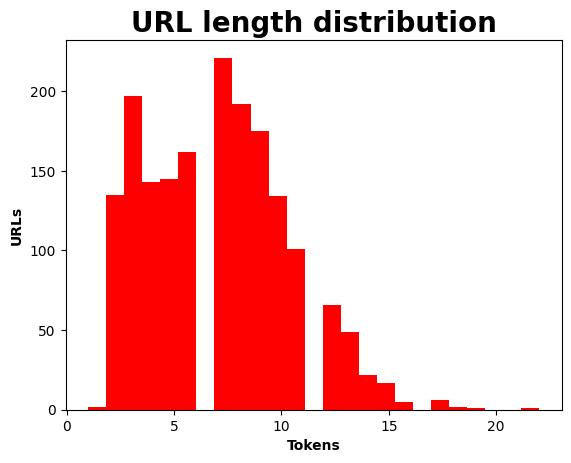

URL length mean: 7 tokens
URL length min: 1 tokens
URL length max: 22 tokens


In [25]:

lengths=[len(url) for url in training_features['url'].tolist()]

training_features['url_len']=lengths

plt.title('URL length distribution', fontsize=20, fontweight='bold')
plt.xlabel('Tokens', fontweight='bold')
plt.ylabel('URLs', fontweight='bold')
plt.hist(lengths, bins=25, color='red')
plt.show()

print(f'URL length mean: {mean(lengths):.0f} tokens')
print(f'URL length min: {min(lengths):.0f} tokens')
print(f'URL length max: {max(lengths):.0f} tokens')

- clean short URL of zero 

In [26]:
training_features['target']=encoded_training_labels
training_features=training_features[training_features['url_len'] > 0]
encoded_training_labels=training_features['target']
training_features.drop(['target'], axis=1, inplace=True)

- Clean long URLs

In [27]:
training_features[training_features['url_len'] > 15]


,url,url_len
2159,"[http, washingtonpost, politics, court, suprem...",17
2142,"[http, ohio, news, ohio, university, professor...",16
219,"[http, judiciary, senate, press, release, chai...",17
1433,"[http, marketwatch, story, reason, stock, mark...",16
2320,"[http, washingtonpost, local, public, safety, ...",16
319,"[http, reuters, article, stock, weekahead, wal...",17
1866,"[http, washingtonpost, national, security, rus...",18
1724,"[http, section, live, update, protest, racial,...",16
2334,"[http, reuters, article, russia, putin, vote, ...",17
2077,"[http, blog, microsoft, blog, microsoft, launc...",17


- No significant long URLs identified, all items look valid/reliable news sites! 

### 3.4 Vectorization 

In [28]:
tokens_list=training_features['url']
tokens_list=[' '.join(tokens) for tokens in tokens_list]
vectorizer=TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
encoded_training_features=vectorizer.fit_transform(tokens_list).toarray()
feature_names=vectorizer.get_feature_names_out()
encoded_training_features=pd.DataFrame(encoded_training_features, columns=feature_names)
print(f'Encoded features shape: {encoded_training_features.shape}')

Encoded features shape: (1776, 386)


In [29]:
encoded_training_features.head()

,abortion,account,action,administration,advertising,afghanistan,ahead,album,amazon,america,...,wordpress,work,worker,world,wwdc,year,york,youtu,youtube,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.702265,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418558,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### 3.5 TF-IDF value distribution  

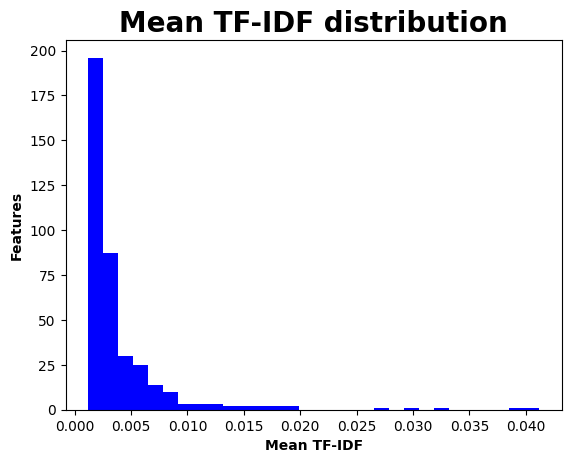

In [30]:
feature_means=encoded_training_features.mean().tolist()

plt.title('Mean TF-IDF distribution', fontsize=20, fontweight='bold')
plt.xlabel('Mean TF-IDF', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.hist(feature_means, bins=30, color='blue')
plt.show()

- Many features with very small or zero TF-IDF values! 

## 4. SVM Model 
### 4.1 Baseline Model Performance 

In [31]:
cv_folds=7
baseline_model=SVC(class_weight='balanced')
scores=cross_val_score(baseline_model, encoded_training_features, encoded_training_labels, cv=cv_folds, n_jobs=-1)

cross_val_scores={'Model': ['Baseline']*cv_folds,'Score': list(scores)}

print(f'Cross validation accuracy: {np.mean(scores)*100:.1f}+/-{np.std(scores)*100:.1f}%')

Cross validation accuracy: 83.9+/-1.4%


### 4.2 Hyperparameter Optimization 

In [32]:
hyperparameters = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']}

model=SVC(class_weight='balanced')
grid=GridSearchCV(model, hyperparameters, scoring='accuracy', cv=cv_folds, n_jobs=-1)
optimization_results=grid.fit(encoded_training_features, encoded_training_labels)
print(f'Best hyperparameters: {grid.best_params_}')

Best hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [33]:
optimized_model=SVC(**grid.best_params_, class_weight='balanced')

# Cross-validate the optimized model on the encoded training data
scores=cross_val_score(
    optimized_model,
    encoded_training_features,
    encoded_training_labels,
    cv=cv_folds,
    n_jobs=-1
)

# Save the optimized cross-validation scores for later
cross_val_scores['Model'].extend(['Optimized']*cv_folds)
cross_val_scores['Score'].extend(scores)

print(f'Cross validation accuracy: {np.mean(scores)*100:.1f}+/-{np.std(scores)*100:.1f}%')

Cross validation accuracy: 93.2+/-1.1%


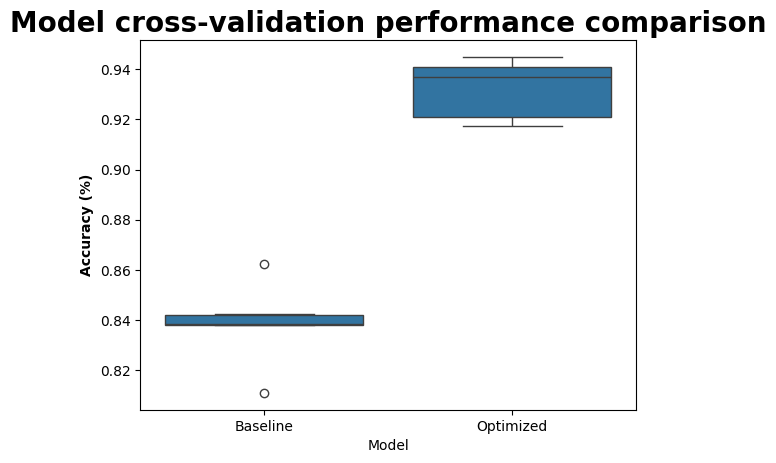

In [34]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison', fontsize=20, fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.show()

## 5. Model evaluation 
### 5.1 Preprocess testing data 

In [35]:
testing_features['url']=testing_features['url'].apply(preprocess_text)
testing_features['url']=testing_features['url'].apply(lemmatize_text)

lengths=[len(url) for url in testing_features['url'].tolist()]

testing_features['url_len']=lengths

testing_features[testing_features['url_len'] > 0]

tokens_list=testing_features['url']
tokens_list=[' '.join(tokens) for tokens in tokens_list]

encoded_testing_features=vectorizer.transform(tokens_list).toarray()

encoded_testing_features=pd.DataFrame(encoded_testing_features, columns=feature_names)
print(f'Encoded features shape: {encoded_testing_features.shape}')

Encoded features shape: (593, 386)


### 5.2 Testing data performance 

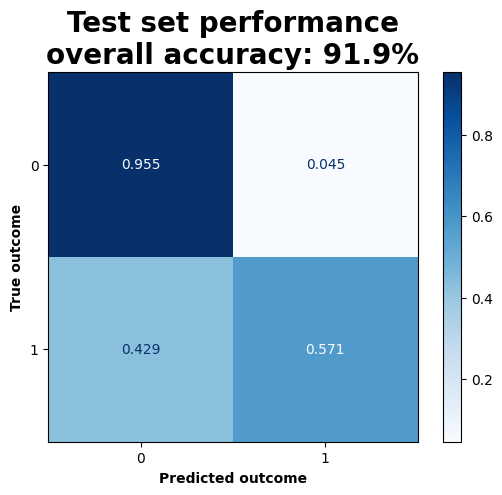

In [38]:
optimized_model.fit(encoded_training_features, encoded_training_labels)
predictions=optimized_model.predict(encoded_testing_features)

accuracy=accuracy_score(predictions, encoded_testing_labels)*100

# Plot the confusion matrix
cm=confusion_matrix(encoded_testing_labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot(cmap='Blues', values_format='.3f')

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%', fontsize=20, fontweight='bold')
plt.xlabel('Predicted outcome', fontweight='bold')
plt.ylabel('True outcome', fontweight='bold')
plt.show()